In [14]:
#importing libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [133]:
class Value:
    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)        
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return  f"Value (data = {self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out  = Value(self.data + other.data, (self, other),'+')
       
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "Only supporting int/float powers for row"
        out = Value(self.data ** other, (self,), f'{other}')
        
        def _backward():
            self.grad += other* (self.data ** (other - 1))* out.grad  #d/dx(x^n) = n * x^n-1
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self,other):  #2*a will be redirected to a*2 here 
        return self*other
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [114]:
a = Value(2.0)
b = Value(4.0)

#These 3 things are almost same
# print(a//b)
# print(a * (1/b))
# print(a * (b**-1))


# a*2 = a.__mul__(2)

# ||ly 2*a = 2.__mul__(a) //which is not possible

print(a/b)
print(a-b)
# print(a * (1//b))

Value (data = 0.5)
Value (data = -2.0)


In [115]:
a = Value(2.0)
a.exp()

Value (data = 7.38905609893065)

In [116]:
 from graphviz import Digraph

In [117]:
def trace(root):
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [118]:
#inputs X1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')
#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1' + 'x2w2' 
n = x1w1x2w2 + b; n.label = 'n' 

o = n.tanh(); o.label = 'o'

In [119]:
o.backward()

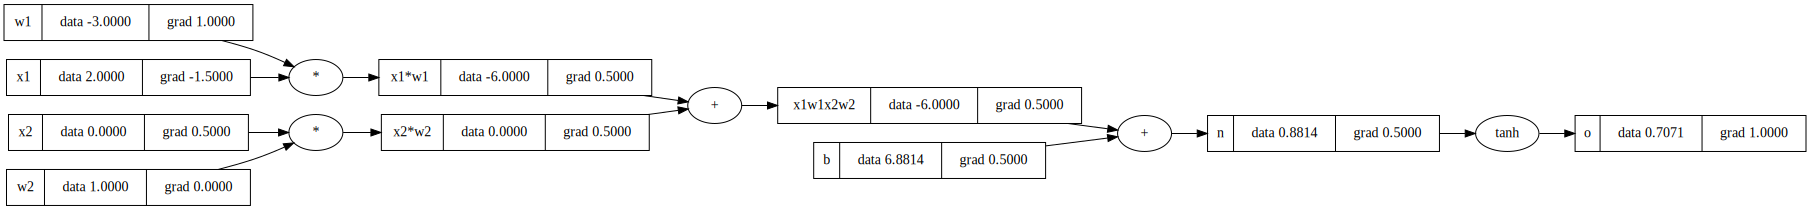

In [120]:
draw_dot(o)

In [121]:
#inputs X1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')
#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1' + 'x2w2' 
n = x1w1x2w2 + b; n.label = 'n' 


e = (2*n).exp()
o = (e -1) / (e+1)

o.label = 'o'

In [122]:
import torch

In [123]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 +b
o = torch.tanh(n)

print(o.data.item())   #calling the item 
o.backward()

print('____')

print('x1:',x1.grad)
print('x1:',x1.grad.item())
print('w1:',w1.grad.item())
print('x2:',x2.grad.item())
print('w2:',w2.grad.item())


0.7071066904050358
____
x1: tensor([-1.5000], dtype=torch.float64)
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


In [124]:
#python uses double precision so we change the tensors to double
torch.Tensor([2.0]).double().dtype

torch.float64

In [125]:
print(o.item()) #gives the value alone
print(o)  #gives whole information

0.7071066904050358
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward>)


In [126]:
import random

In [447]:
class Neuron:
 
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w*x+b
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
            outs = [n(x) for n in self.neurons]
            return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#         params = []
#         for neuron in self.neurons:
#             ps = neuron.parameters()
#             params.extens(ps)
#         return params
    
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [141]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value (data = 0.12199811301726374)

In [142]:
len(n.parameters())

41

In [143]:
n.parameters()

[Value (data = -0.9679416279347091),
 Value (data = -0.6179801682050121),
 Value (data = -0.5819837169754978),
 Value (data = -0.6129418762339203),
 Value (data = -0.07533102703235661),
 Value (data = 0.945772663110416),
 Value (data = -0.12518566968302536),
 Value (data = -0.17246682474343),
 Value (data = 0.8657803465393967),
 Value (data = -0.2748071420677667),
 Value (data = -0.15439157228322453),
 Value (data = -0.26660431409092955),
 Value (data = -0.8441521918843566),
 Value (data = 0.8965761569098911),
 Value (data = 0.0900039858923849),
 Value (data = 0.45046961685206033),
 Value (data = 0.4685779555338707),
 Value (data = 0.009992303296694427),
 Value (data = 0.8865191467145646),
 Value (data = -0.3646021936338011),
 Value (data = -0.46057727986793706),
 Value (data = -0.5696867399471277),
 Value (data = -0.236043714123501),
 Value (data = 0.6584035204737915),
 Value (data = 0.6176111775744932),
 Value (data = -0.7083285548441374),
 Value (data = 0.5798131609494965),
 Value (

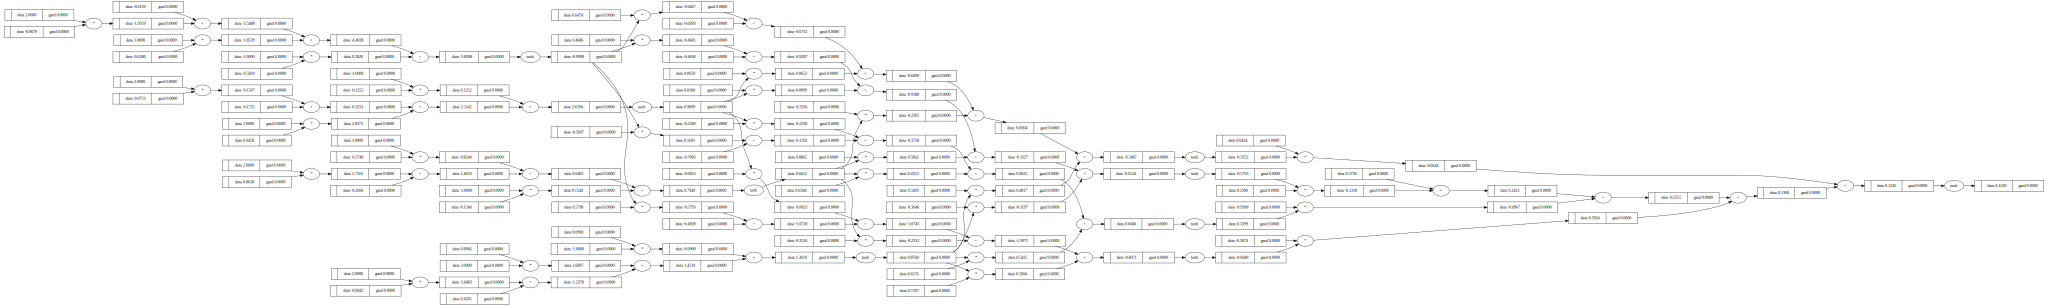

In [144]:
draw_dot(n(x))

In [448]:
#dataset 

#desired features
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  #desired targets

In [458]:

for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    #finding the loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  
    loss
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0    #we need to flush the gradients for every backward 
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    print(k, loss)
    
    
# 6.748583956819029e-05 = 0.00006748583956819029

0 Value (data = 6.742682518688925e-05)
1 Value (data = 6.742387733749148e-05)
2 Value (data = 6.742092976112024e-05)
3 Value (data = 6.741798245773137e-05)
4 Value (data = 6.741503542729305e-05)
5 Value (data = 6.74120886697595e-05)
6 Value (data = 6.740914218509644e-05)
7 Value (data = 6.74061959732672e-05)
8 Value (data = 6.740325003423377e-05)
9 Value (data = 6.740030436795434e-05)
10 Value (data = 6.739735897439419e-05)
11 Value (data = 6.739441385351694e-05)
12 Value (data = 6.73914690052774e-05)
13 Value (data = 6.738852442964553e-05)
14 Value (data = 6.73855801265813e-05)
15 Value (data = 6.738263609604277e-05)
16 Value (data = 6.737969233799833e-05)
17 Value (data = 6.737674885240484e-05)
18 Value (data = 6.737380563922705e-05)
19 Value (data = 6.737086269842635e-05)


In [451]:
# n.layers[0].neurons[0].w[0].data

In [452]:
# n.layers[0].neurons[0].w[0].data

In [453]:
ypred

[Value (data = 0.9988372709391075),
 Value (data = -0.9938716975986038),
 Value (data = -0.9948860860079983),
 Value (data = 0.9984227311435834)]

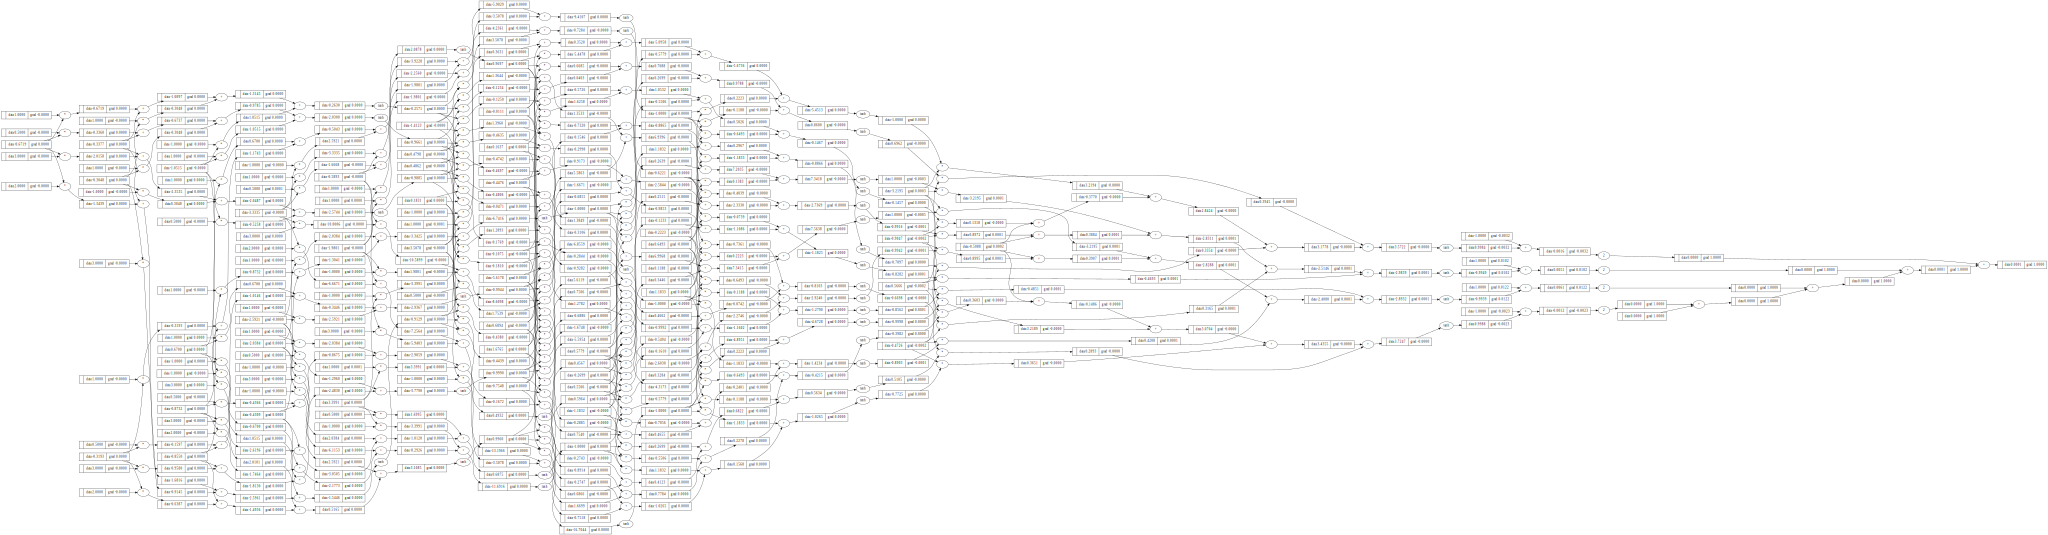

In [459]:
draw_dot(loss)